#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento

# Project 4: Time Series Forecasting

## Creating the Dataframe

In [326]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#load data
AAPL_path = "./AAPL.csv"

df = pd.read_csv(AAPL_path)

print(AAPL_path)
print(df.head())

./AAPL.csv
         Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.023186  117258400.0
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.021977   43971200.0
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.020364   26432000.0
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.020868   21610400.0
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.021473   18362400.0


In [327]:
# filter out dropping Date and Adj Close 

df_filtered = df.drop(columns=['Date', 'Adj Close'])
print("First 5 rows of the filtered data:")
print(df_filtered.head())

First 5 rows of the filtered data:
       Open      High       Low     Close       Volume
0  0.513393  0.515625  0.513393  0.513393  117258400.0
1  0.488839  0.488839  0.486607  0.486607   43971200.0
2  0.453125  0.453125  0.450893  0.450893   26432000.0
3  0.462054  0.464286  0.462054  0.462054   21610400.0
4  0.475446  0.477679  0.475446  0.475446   18362400.0


In [328]:
# drop rows with NaN values

df_filtered = df_filtered.dropna()

In [329]:
close = df_filtered['Close'].tolist()
close[0:5]

[0.513393, 0.486607, 0.450893, 0.462054, 0.475446]

## Normalizing Input Features

In [330]:
df_scaled = (df_filtered - df_filtered.mean()) / df_filtered.std()

# Confirm the normalization
print("Sample of scaled data (first 5 rows):")
df_scaled[0:5]

Sample of scaled data (first 5 rows):


,Open,High,Low,Close,Volume
0,-0.547665,-0.548357,-0.546670,-0.547549,0.339526
1,-0.548200,-0.548935,-0.547258,-0.548132,-0.503884
2,-0.548977,-0.549706,-0.548042,-0.548909,-0.705730
3,-0.548782,-0.549465,-0.547797,-0.548666,-0.761218
4,-0.548491,-0.549176,-0.547503,-0.548374,-0.798597


## Creating Windows to Send Data Properly

In [331]:
def to_sequences(SEQUENCE_SIZE, data, output):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data.iloc[i:i + SEQUENCE_SIZE].values.flatten()
        after_window = output[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [332]:
SEQUENCE_SIZE = 7
X,y = to_sequences(SEQUENCE_SIZE, df_scaled, close)

print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

X[0:5]

Shape of X: (9547, 35, 1)
Shape of y: (9547,)


array([[[-0.54766515],
        [-0.54835724],
        [-0.54667033],
        [-0.54754873],
        [ 0.33952598],
        [-0.54819953],
        [-0.54893537],
        [-0.54725828],
        [-0.5481316 ],
        [-0.50388387],
        [-0.5489768 ],
        [-0.54970621],
        [-0.5480422 ],
        [-0.54890874],
        [-0.70572994],
        [-0.54878248],
        [-0.54946531],
        [-0.54779722],
        [-0.54866587],
        [-0.76121828],
        [-0.54849102],
        [-0.54917625],
        [-0.54750326],
        [-0.54837446],
        [-0.79859718],
        [-0.54785948],
        [-0.54854996],
        [-0.54686632],
        [-0.54774303],
        [-0.87000378],
        [-0.54732509],
        [-0.54801999],
        [-0.54632737],
        [-0.54720873],
        [-0.90242031]],

       [[-0.54819953],
        [-0.54893537],
        [-0.54725828],
        [-0.5481316 ],
        [-0.50388387],
        [-0.5489768 ],
        [-0.54970621],
        [-0.5480422 ],
        [

In [333]:
y[0:5]

array([0.551339, 0.580357, 0.633929, 0.642857, 0.627232])

## Data Splitting and Preparation

In [334]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)
X_test, X_test_dummy, y_test, y_test_dummy = train_test_split(X_test, y_test, test_size=0.02, random_state=305)

print("Training set has {} records.".format(len(X_train)))
print("Test set has {} records.".format(len(X_test)))
print("")
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Training set has 6682 records.
Test set has 2807 records.

Shape of X_train: (6682, 35, 1)
Shape of y_train: (6682,)
Shape of X_test: (2807, 35, 1)
Shape of y_test: (2807,)


In [335]:
X_train[0:5]

array([[[ 0.20531664],
        [ 0.20836347],
        [ 0.21190394],
        [ 0.21506875],
        [ 0.07411965],
        [ 0.21399103],
        [ 0.21486939],
        [ 0.20889369],
        [ 0.21034367],
        [ 1.14945592],
        [ 0.20920308],
        [ 0.20484844],
        [ 0.20017643],
        [ 0.20931786],
        [ 0.62116473],
        [ 0.21389779],
        [ 0.20904182],
        [ 0.20390794],
        [ 0.20160856],
        [ 1.11430042],
        [ 0.24579718],
        [ 0.24295877],
        [ 0.24395066],
        [ 0.24708716],
        [ 1.81649212],
        [ 0.24405612],
        [ 0.26300066],
        [ 0.24542442],
        [ 0.26962437],
        [ 1.27282241],
        [ 0.27436984],
        [ 0.27974333],
        [ 0.27928991],
        [ 0.2831778 ],
        [ 1.28298077]],

       [[ 3.25220586],
        [ 3.24137464],
        [ 3.24245387],
        [ 3.2684452 ],
        [-0.67062278],
        [ 3.25220586],
        [ 3.22583447],
        [ 3.26725728],
        [

In [336]:
y_train[0:5]

array([ 38.5     , 169.979996,   0.321429,   0.660714,   0.642857])

## Build the Fully-Connected Neural Network (FCNN)

In [337]:
# Define the FCNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Set Up Callbacks and Train the Model


In [338]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_fcnn_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print training completion
print("FCNN model training complete.")


Epoch 1/100


209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1730.6216 - mse: 1730.6216 - val_loss: 42.7933 - val_mse: 42.7933
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 38.2036 - mse: 38.2036 - val_loss: 27.6891 - val_mse: 27.6891
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 24.2509 - mse: 24.2509 - val_loss: 16.5514 - val_mse: 16.5514
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 14.1672 - mse: 14.1672 - val_loss: 7.1397 - val_mse: 7.1397
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 6.6331 - mse: 6.6331 - val_loss: 3.2383 - val_mse: 3.2383
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 2.6430 - mse: 2.6430 - val_loss: 1.9591 - val_mse: 1.9591
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 2.1854 - mse: 2.1854 - val_loss: 1.6600 - val_mse: 1.6600
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2.0449 - mse: 2.0449 - val_loss: 1.6373 - val_mse: 1.6373
Epoch 9/100
209/209 ━━━━━━━━

## Evaluate the Model and Plot the Regression Lift Chart

In [339]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on the test set
y_pred = model.predict([X_test_dummy])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_dummy, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepWARNING:tensorflow:6 out of the last 31 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018119CF3100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Root Mean Square Error (RMSE): 0.6315607419956101


Test RMSE: 0.6315607419956101


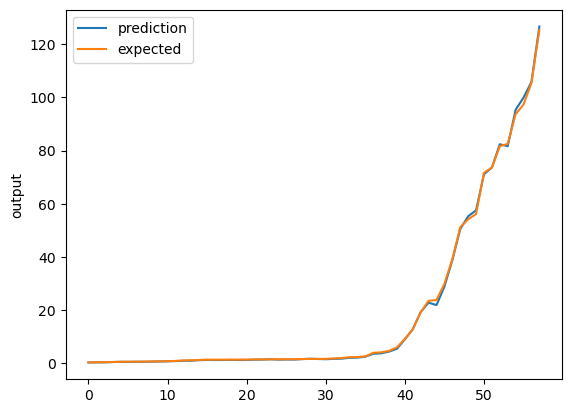

In [340]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_dummy, y_pred))
print("Test RMSE:", rmse)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

chart_regression(y_pred.flatten(), y_test_dummy, sort=True)
